In [1]:
import time
import numpy as np
import pandas as pd
from datetime import datetime

from ftx import FtxClient
from pycoingecko import CoinGeckoAPI

from IPython.display import display, clear_output
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Get futures and funding rates from FTX

In [2]:
def get_futures_data() -> pd.DataFrame:
    ftx = FtxClient()

    futures = ftx.get_futures()
    funding_rates = ftx.get_funding_rates()

    df = pd.DataFrame(columns=["market", "name", "open_interest", "funding_rate"])

    idx = 0
    for future in futures:
        if future["perpetual"]:
            for funding in funding_rates:
                if funding["future"] == future["name"]:
                    funding_rate = funding["rate"]
                    break
            df.loc[idx] = [future["name"], future["underlying"], future["openInterestUsd"], funding_rate]
            idx += 1
    
    return df

# Get market caps from CoinGecko

In [3]:
def get_market_cap_data(df: pd.DataFrame) -> pd.DataFrame:
    cg = CoinGeckoAPI()
    markets = cg.get_coins_markets(vs_currency=["usd"], per_page=250)
    
    market_caps = np.zeros(len(df))

    for idx, name in enumerate(df["name"]):
        market_cap = 0
        for market in markets:
            if name.lower() == market["symbol"].lower():
                market_cap = market["market_cap"]
                break
        market_caps[idx] = market_cap

    df["market_cap"] = market_caps

    # Remove any values without market caps
    df = df[df["market_cap"] != 0]
    df = df.reset_index(drop=True)
    
    return df

# Calculate the FOM metric

The calculation of the derived metric is simple, the idea is to take the open interest in the market $i$ and normalize it with the market cap. This ratio can be then multiplied with the absolute value of the funding rate. A large value would indicate a strong perp bias towards one direction. The direction is indicated by the sign of the funding rate. 

Let, 
$$ FR_i = \text{funding rate of market i} $$
$$ OI_i = \text{open interest of market i} $$
$$ MC_i = \text{market cap of market i} $$


The derived FOM metric, 

$$ FOM_i = \left(\frac{OI_i}{MC_i}\right) \times abs(FR_i) $$

In [9]:
df = get_futures_data()
df = get_market_cap_data(df)
df["oi_macp_ratio"] = df["open_interest"] / df["market_cap"]
df["fom"] = df["oi_macp_ratio"] *  df["funding_rate"].abs()
df = df.sort_values("fom", ascending=False)

# Plotting the FOM

We see a strong variation in FOM across different cryptos. We can filter this by looking at the top 5 percentile.

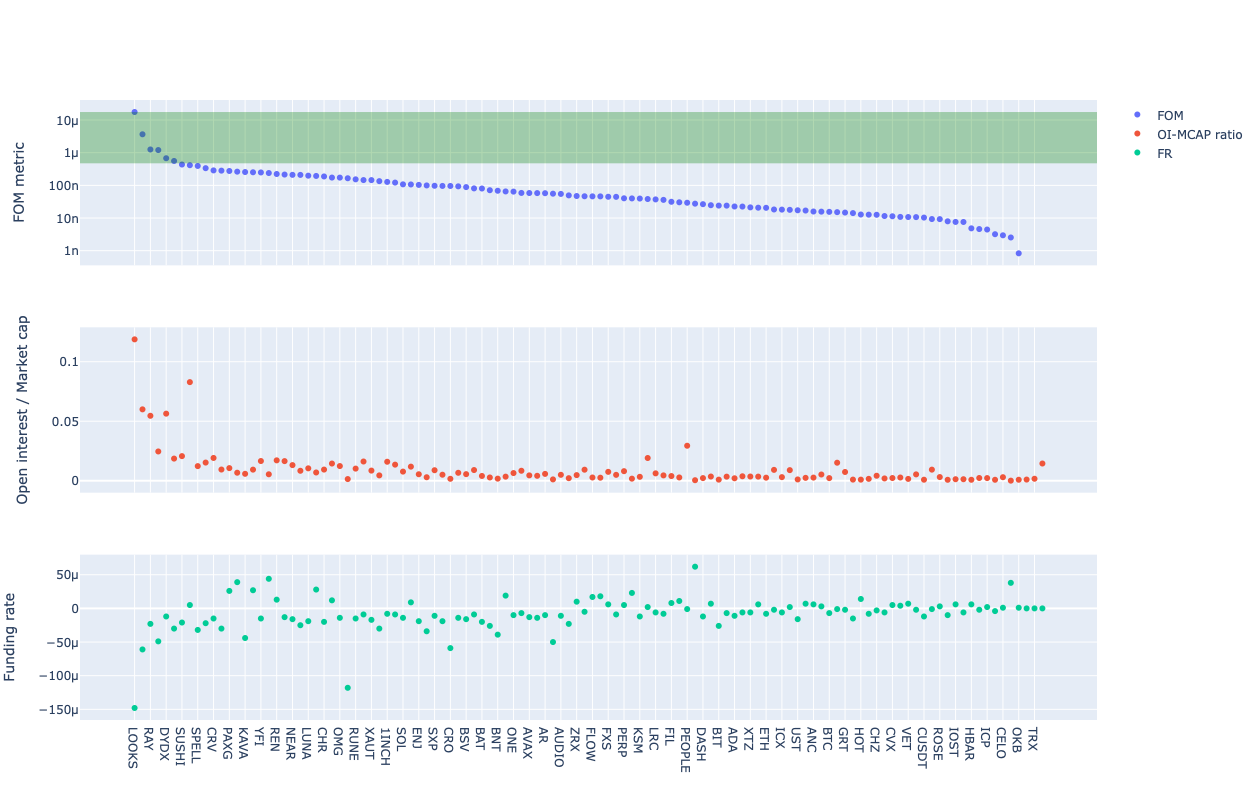

In [55]:
fig = make_subplots(rows=3, cols=1, shared_xaxes=True)

fig.add_trace(
    go.Scatter(
        x=df["name"],
        y=df["fom"],
        mode="markers",
        name="FOM"
    ),
    row=1,
    col=1
)

top_5_percentile = np.percentile(df["fom"], 95)

fig.add_hrect(
    y0=top_5_percentile,
    y1=df["fom"].max(),
    fillcolor="green",
    opacity=0.3,
    line_width=0,
)

fig.add_trace(
    go.Scatter(
        x=df["name"],
        y=df["oi_macp_ratio"],
        mode="markers",
        name="OI-MCAP ratio"
    ),
    row=2,
    col=1
)

fig.add_trace(
    go.Scatter(
        x=df["name"],
        y=df["funding_rate"],
        mode="markers",
        name="FR"
    ),
    row=3,
    col=1
)

fig.add_vrect(
    x0=top_5_percentile,
    x1=df["fom"].max(),
    fillcolor="green",
    opacity=0.3,
    line_width=0,
)

fig['layout']['yaxis']['type'] = 'log'
fig['layout']['yaxis']['title'] = 'FOM metric'

fig['layout']['yaxis2']['title'] = 'Open interest / Market cap'
fig['layout']['yaxis3']['title'] = 'Funding rate'

fig.update_layout(
    height=800, width=1200
)

# fig.write_image("../images/fom_metric.png")
fig.show()

In [11]:
df[df["fom"] > top_5_percentile]

,market,name,open_interest,funding_rate,market_cap,oi_macp_ratio,fom
63,LOOKS-PERP,LOOKS,4.207979e+07,-0.000148,3.542017e+08,0.118802,1.758266e-05
48,GMT-PERP,GMT,7.905858e+07,-0.000061,1.318064e+09,0.059981,3.658832e-06
81,RAY-PERP,RAY,1.446990e+07,-0.000023,2.651221e+08,0.054578,1.255299e-06
105,WAVES-PERP,WAVES,5.124565e+07,-0.000049,2.084101e+09,0.024589,1.204854e-06
34,DYDX-PERP,DYDX,2.374216e+07,-0.000012,4.211963e+08,0.056368,6.764208e-07
10,AXS-PERP,AXS,6.927168e+07,-0.000030,3.724553e+09,0.018599,5.579597e-07


## LooksRare and STEPN
Intrestingly, we see names like LooksRare (LOOKS) and STEPN (GMT) showing very strong negative bias. The case of GMT is particularly interesting, as the team recently announced a buyback and burn mechanism. From the data, the futures market participants do not appear to believe that will lead to positive price action for GMT. The token has performed reasonably well, and is currently at $2.19 (over 330% since listing, and several thousand percent for private investors). Could this be a mechanism for hedging their position?

## Smooth Love Potion
Another intersting case is Smooth Love Position (SLP), where the bias leans positive. The SLP token has not performed so strongly, and is currently down over 94% from listing. The SLP chart is quite interesting, as it has these very large impulse upward moves on high volume. These moves turn into wicks, as it appears people are selling into the impulse. Could the strong positive perp bias be an indication of a potential upcoming move?

# Plot the variation of FOM with time

In [ ]:
fig = make_subplots()

while True:
    clear_output(wait=True)
    
    df = get_futures_data()
    df = get_market_cap_data(df)
    df["oi_macp_ratio"] = df["open_interest"] / df["market_cap"]
    df["fom"] = df["oi_macp_ratio"] *  df["funding_rate"].abs()
    df = df.sort_values("fom", ascending=False).head()
    
    display(df)
    
    fig.append_trace(
        go.Scatter(
            x=df["market"],
            y=df["fom"],
            mode="markers",
            name=f"{datetime.now()}"
        ),
        row=1,
        col=1,
    )

    fig.show()
    
    time.sleep(60 * 30)